In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
eagle205=pd.read_csv('eagle205.csv')

In [3]:
eagle205

,Unnamed: 0,period,Unnamed: 0.1,day,Gas Volume (MMscf),flowrate,Gas Lift Inj Volume (MMscf),Pressure Source _Tubing Pressure,Casing_Pressure_ksia,Tubing_Pressure_ksia,Active_Pressure_ksia,Line_Pressure_ksia,Calculated_Sandface_Pressure_ksia,water_thousand_bbl
0,EAGLE,EAGLE_205.0_1483.0,3592,0.0,0.15700,316.730,0.000,1,0.261669,0.400000,0.400000,0.014696,3.052517,0.19700
1,EAGLE,EAGLE_205.0_1483.0,3593,1.0,0.15400,393.412,0.000,1,0.262491,0.250000,0.250000,0.014696,2.730096,0.08000
2,EAGLE,EAGLE_205.0_1483.0,3594,2.0,0.15100,324.598,0.000,1,0.263314,0.380000,0.380000,0.014696,2.853773,0.06800
3,EAGLE,EAGLE_205.0_1483.0,3595,3.0,0.14900,390.811,0.000,1,0.264137,0.280000,0.280000,0.014696,2.777323,0.07100
4,EAGLE,EAGLE_205.0_1483.0,3596,4.0,0.14800,414.277,0.000,1,0.264960,0.280000,0.280000,0.014696,2.827907,0.09100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,EAGLE,EAGLE_205.0_1483.0,4751,1159.0,0.05635,112.910,0.339,1,0.689696,0.094696,0.094696,0.085197,0.965118,0.06500
1160,EAGLE,EAGLE_205.0_1483.0,4752,1160.0,0.07729,126.250,0.365,1,0.699696,0.104696,0.104696,0.104611,0.941650,0.06800
1161,EAGLE,EAGLE_205.0_1483.0,4753,1161.0,0.07472,122.090,0.392,1,0.680696,0.094696,0.094696,0.107219,0.938363,0.09000
1162,EAGLE,EAGLE_205.0_1483.0,4754,1162.0,0.08539,182.500,0.418,1,0.694696,0.114696,0.114696,0.107219,1.088944,0.10100


In [4]:
np.random.seed(42)
dates = pd.date_range('2018-01-01', periods=1164)

# Временные ряды
values_time_series = eagle205['flowrate']


# Экзогенные признаки
exog_feature1 = eagle205['Casing_Pressure_ksia']
exog_feature2 = eagle205['Tubing_Pressure_ksia']
exog_feature3 = eagle205['Active_Pressure_ksia']
exog_feature4 = eagle205['Line_Pressure_ksia']
exog_feature5 = eagle205['Calculated_Sandface_Pressure_ksia']
exog_feature6 = eagle205['water_thousand_bbl']
exog_feature7 = eagle205['Gas Lift Inj Volume  (MMscf)']
exog_feature8 = eagle205['Gas Volume (MMscf)']

# Создание DataFrame с временными рядами и экзогенными признаками
data = pd.DataFrame({'date': dates, 'time_series': values_time_series,
                      'Casing_Pressure_ksia': exog_feature1, 'Tubing_Pressure_ksia': exog_feature2, 'Active_Pressure_ksia': exog_feature3, 'Line_Pressure_ksia': exog_feature4,
                   'Calculated_Sandface_Pressure_ksia': exog_feature5, 'water_thousand_bbl': exog_feature6, 'Gas Lift Inj Volume  (MMscf)': exog_feature7, 'Gas Volume (MMscf)': exog_feature8 })
data.set_index('date', inplace=True)

In [5]:
data

,time_series,Casing_Pressure_ksia,Tubing_Pressure_ksia,Active_Pressure_ksia,Line_Pressure_ksia,Calculated_Sandface_Pressure_ksia,water_thousand_bbl,Gas Lift Inj Volume (MMscf),Gas Volume (MMscf)
date,,,,,,,,,
2018-01-01,316.730,0.261669,0.400000,0.400000,0.014696,3.052517,0.19700,0.000,0.15700
2018-01-02,393.412,0.262491,0.250000,0.250000,0.014696,2.730096,0.08000,0.000,0.15400
2018-01-03,324.598,0.263314,0.380000,0.380000,0.014696,2.853773,0.06800,0.000,0.15100
2018-01-04,390.811,0.264137,0.280000,0.280000,0.014696,2.777323,0.07100,0.000,0.14900
2018-01-05,414.277,0.264960,0.280000,0.280000,0.014696,2.827907,0.09100,0.000,0.14800
...,...,...,...,...,...,...,...,...,...
2021-03-05,112.910,0.689696,0.094696,0.094696,0.085197,0.965118,0.06500,0.339,0.05635
2021-03-06,126.250,0.699696,0.104696,0.104696,0.104611,0.941650,0.06800,0.365,0.07729
2021-03-07,122.090,0.680696,0.094696,0.094696,0.107219,0.938363,0.09000,0.392,0.07472


In [6]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)


plotly_df(data, title = "Oil Debit")

In [7]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(data.time_series, 24)

130.88458333333335

In [8]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(data[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

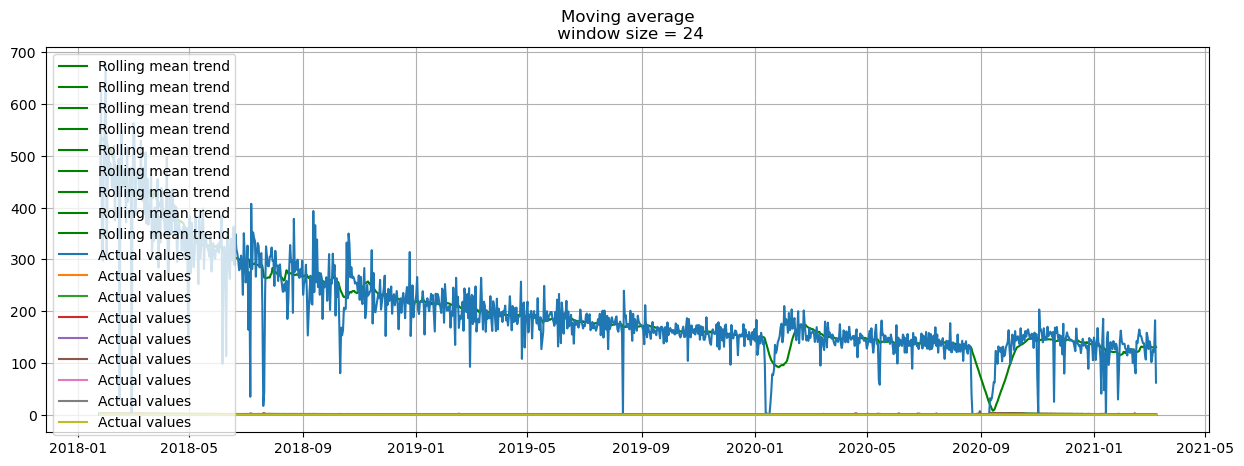

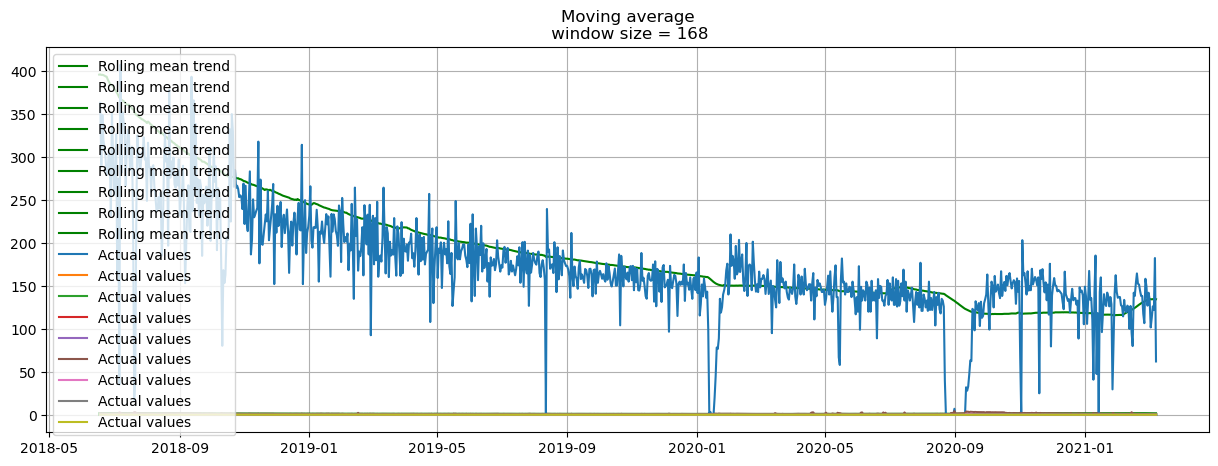

In [9]:
plotMovingAverage(data, 24) # сглаживаем по дням
plotMovingAverage(data, 24*7) # сглаживаем по неделям

In [10]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

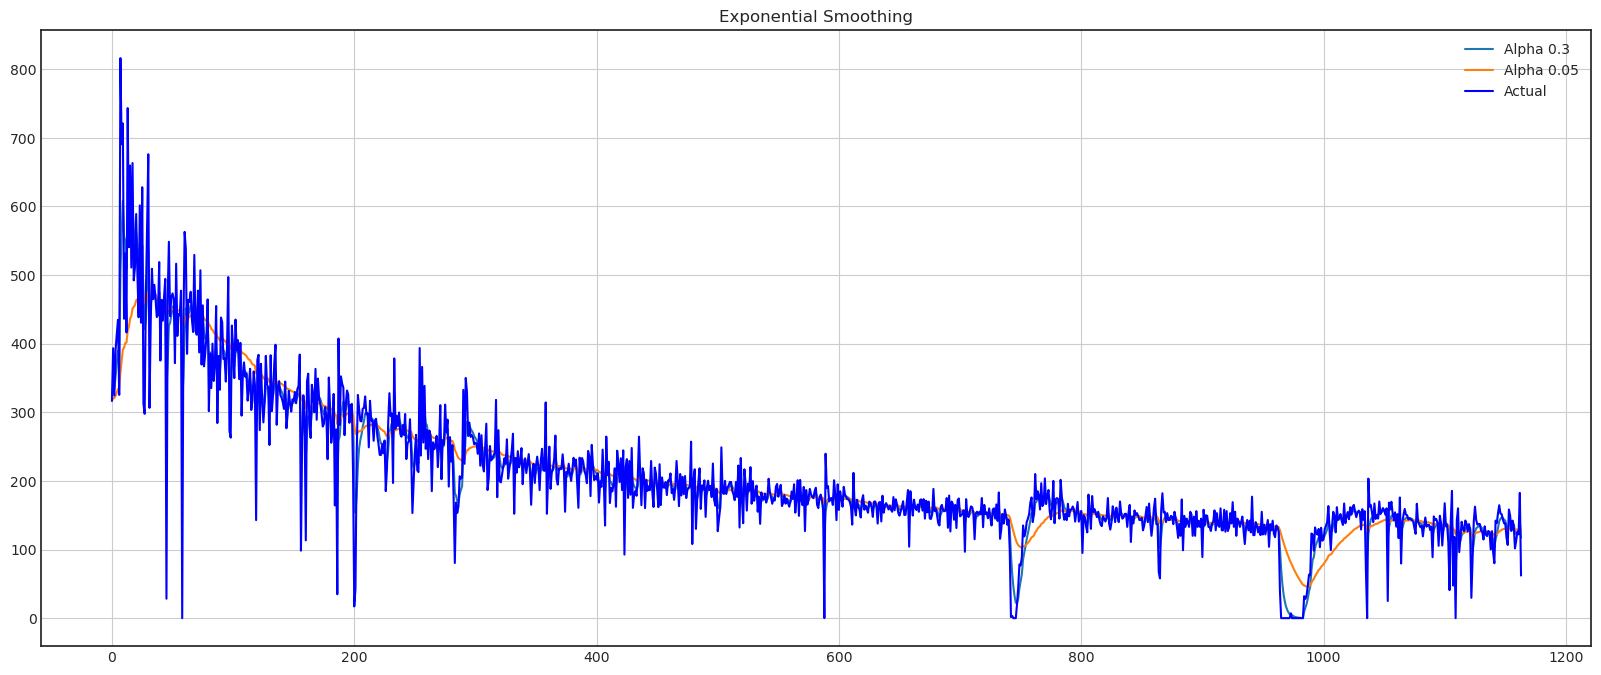

In [11]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(data.time_series, alpha), label="Alpha {}".format(alpha))
    plt.plot(data.time_series.values, "b", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"ES model\n Mean absolute error 48 debits\n R^2 0.57 \n MAPE 0.37")
    plt.title("Exponential Smoothing")
    plt.grid(True)

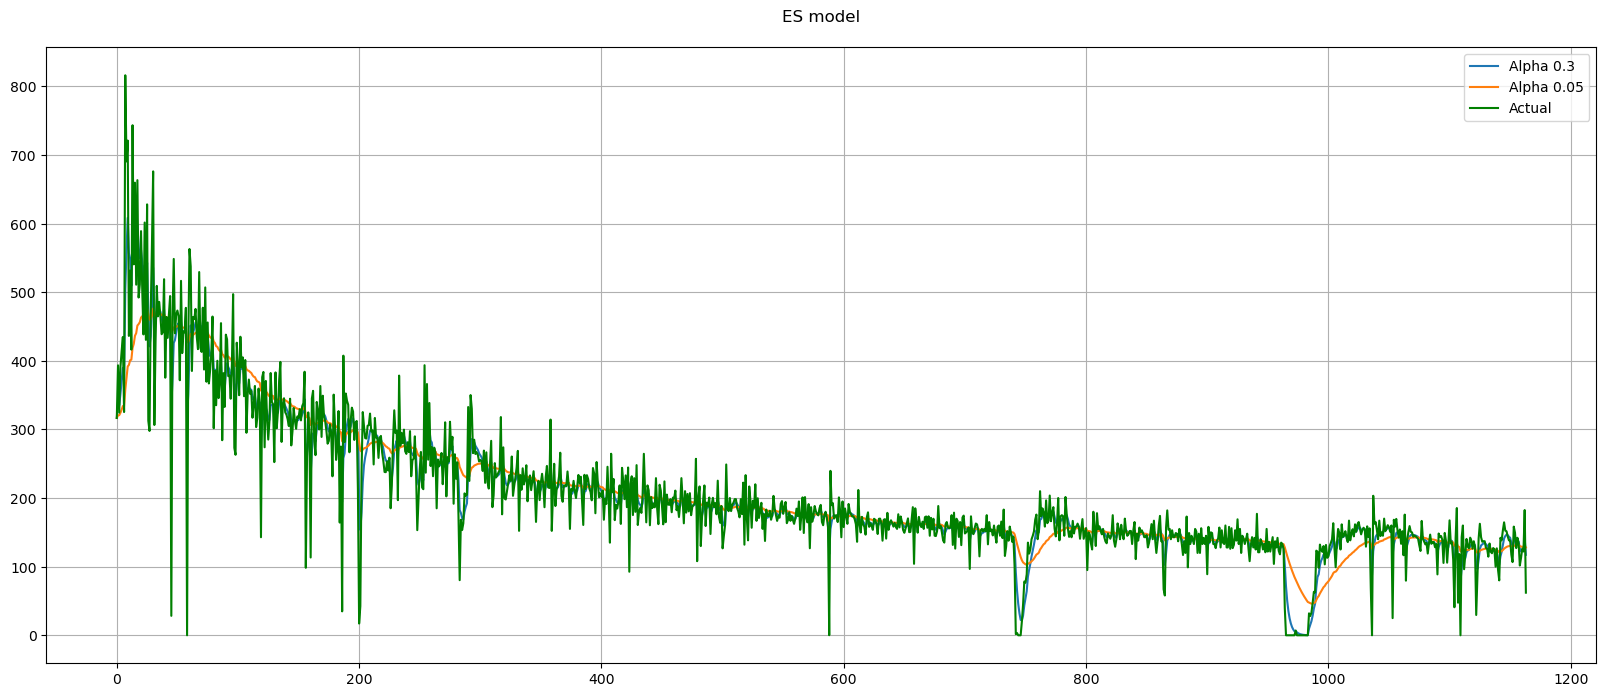

In [12]:
plt.figure(figsize=(20, 8))
for alpha in [0.3, 0.05]:
    plt.plot(exponential_smoothing(data.time_series, alpha), label="Alpha {}".format(alpha))
plt.plot(data.time_series.values,"green" , label = "Actual")
plt.legend(loc="best")
plt.axis('tight')
plt.title(f"ES model\n")
plt.grid(True)

In [13]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += (self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [14]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [15]:
dataset = pd.DataFrame({'date': dates, 'time_series': values_time_series,
                     'Casing_Pressure_ksia': exog_feature1, 'Tubing_Pressure_ksia': exog_feature2, 'Active_Pressure_ksia': exog_feature3, 'Line_Pressure_ksia': exog_feature4,
                   'Calculated_Sandface_Pressure_ksia': exog_feature5, 'water_thousand_bbl': exog_feature6, 'Gas Lift Inj Volume  (MMscf)': exog_feature7, 'Gas Volume (MMscf)': exog_feature8  })
dataset.set_index('date', inplace=True)

In [16]:
%%time
#data = dataset.time_series[:-100] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.005248430115719016 0.01792175436410698 0.05027710246706091
Wall time: 18.3 s


In [17]:
data = dataset.time_series
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [18]:
data

date
2018-01-01    316.730
2018-01-02    393.412
2018-01-03    324.598
2018-01-04    390.811
2018-01-05    414.277
               ...   
2021-03-05    112.910
2021-03-06    126.250
2021-03-07    122.090
2021-03-08    182.500
2021-03-09     62.080
Name: time_series, Length: 1164, dtype: float64

In [19]:
len(data)

1164

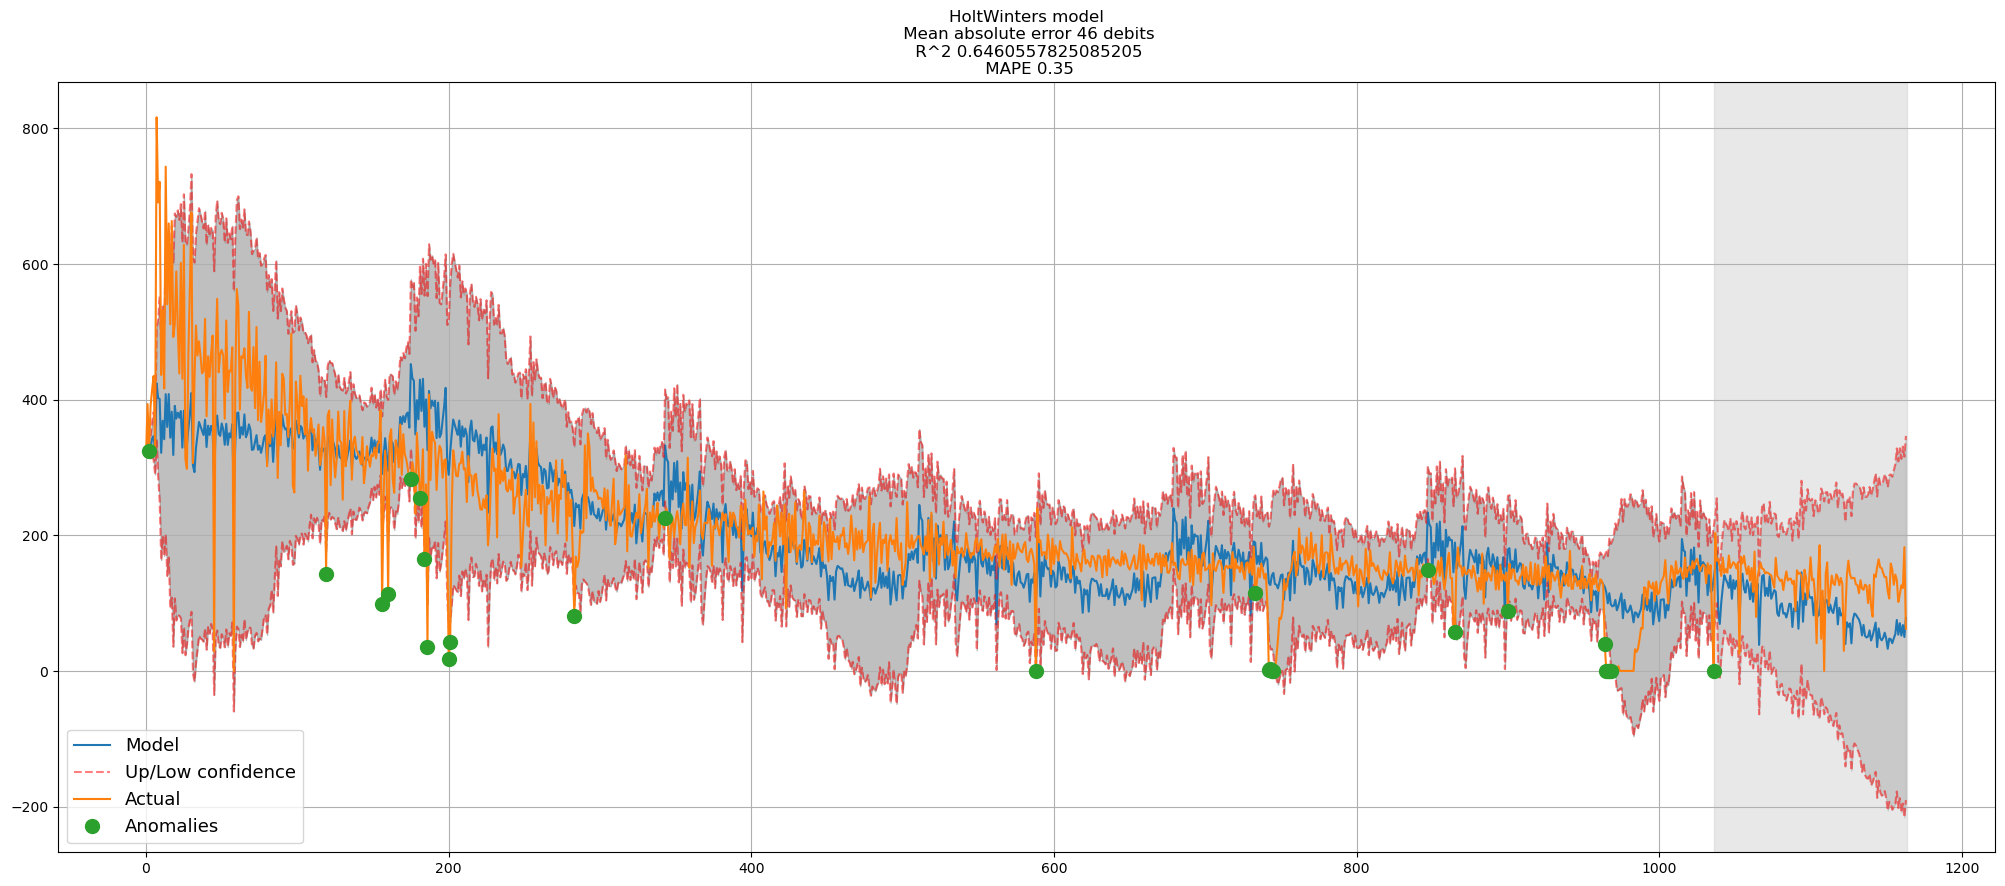

In [20]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.title(f"HoltWinters model\n Mean absolute error {round(mean_absolute_error(data.dropna().values, model.result))} debits\n R^2 {r2_score(data.dropna().values, model.result)}\n MAPE 0.35")
   
   
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

Критерий Дики-Фуллера: p=0.001663


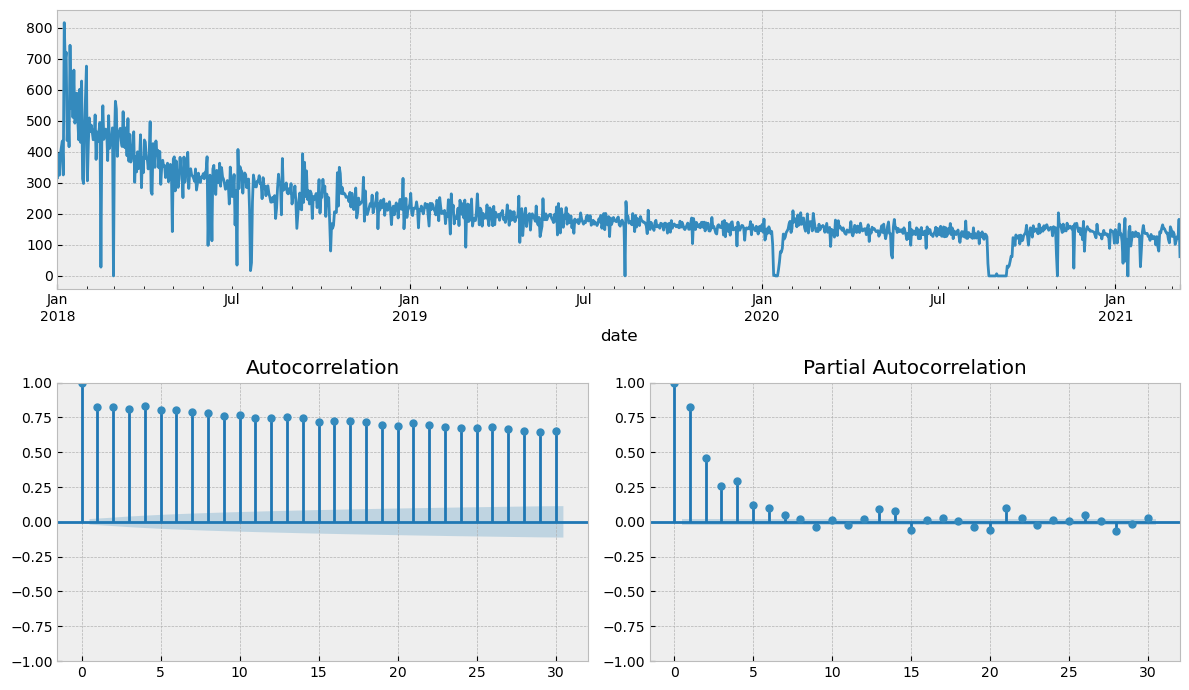

In [21]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        #ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        #print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
    return 

tsplot(dataset.time_series, lags=30)


Критерий Дики-Фуллера: p=0.001663
Оптимальный параметр преобразования Бокса-Кокса: 0.585009


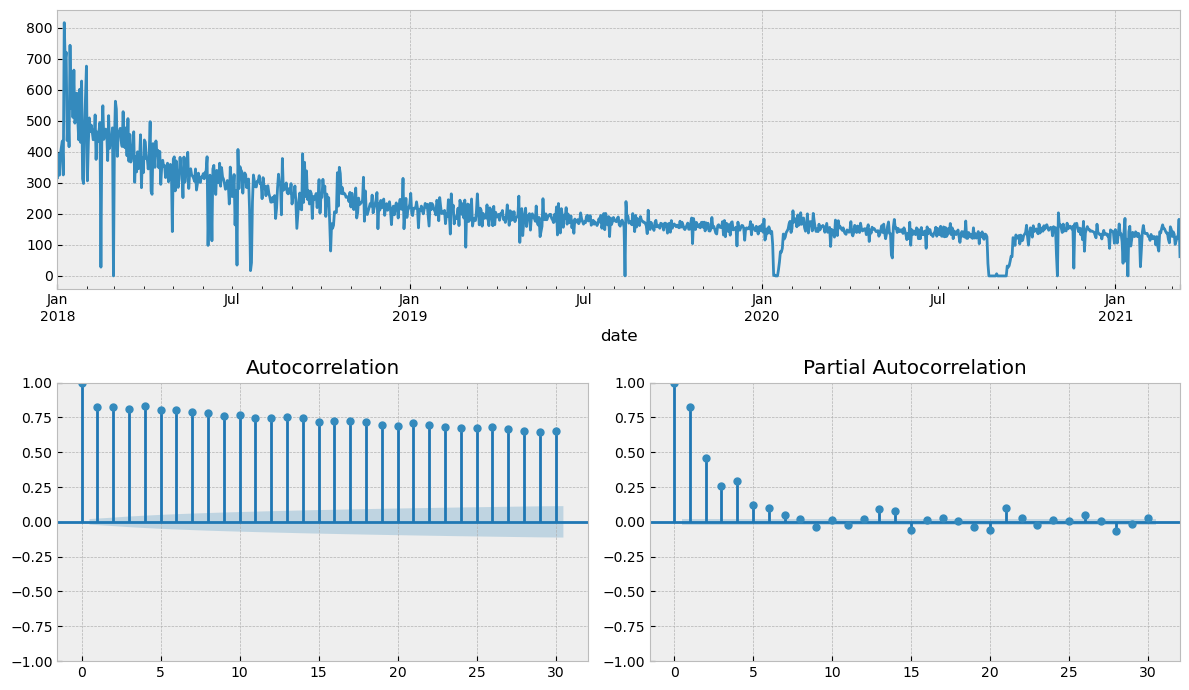

In [22]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = dataset.copy()
data['Debit_box'], lmbda = scs.boxcox(dataset.time_series+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(dataset.time_series, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000000


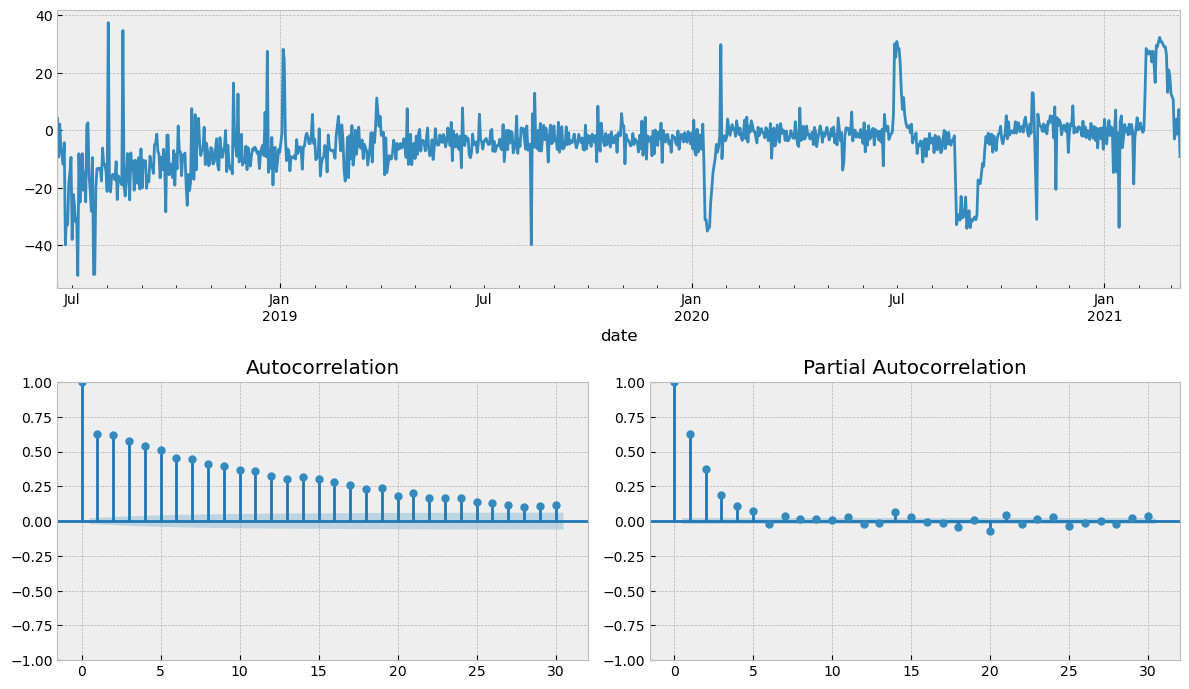

In [23]:
data['Debit_box_season'] = data.Debit_box - data.Debit_box.shift(24*7)
tsplot(data.Debit_box_season[24*7:], lags=30)

Критерий Дики-Фуллера: p=0.000000


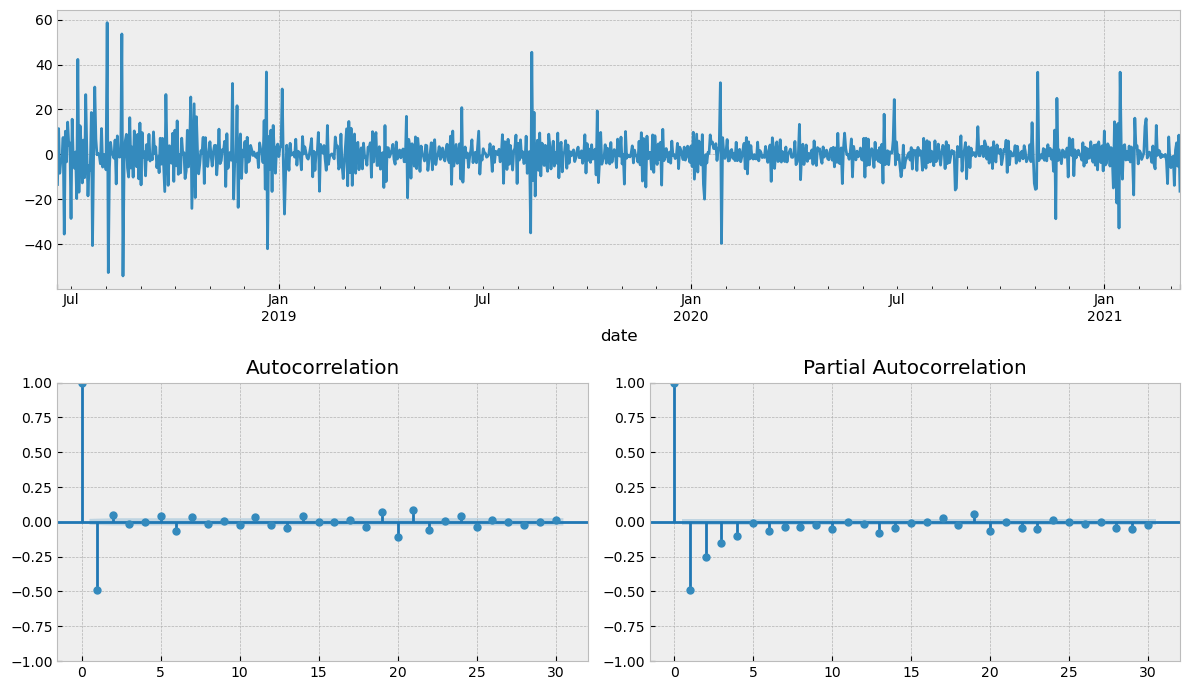

In [24]:
data['Debit_box_season_diff'] = data.Debit_box_season - data.Debit_box_season.shift(1)
tsplot(data.Debit_box_season_diff[24*7+1:], lags=30)

In [25]:
ps = range(2, 5)
d=1
qs = range(2, 4)
Ps = range(2, 5)
D=0
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

18

In [27]:

%%time
results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Debit_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24*7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

Statespace Model Results
 p=4, d=1, q = 4, P=4, D=0 Q=0


UsageError: Line magic function `%%time` not found.


In [28]:
arima_model = sm.tsa.arima.ARIMA(data.Debit_box, order=(4, d, 3) 
                                        ).fit()
print(arima_model.summary())  

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              Debit_box   No. Observations:                 1164
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -3650.576
Date:                Fri, 28 Jun 2024   AIC                           7317.152
Time:                        14:15:07   BIC                           7357.622
Sample:                    01-01-2018   HQIC                          7332.420
                         - 03-09-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5916      0.330      1.795      0.073      -0.054       1.237
ar.L2          0.0853      0.317      0.269      0.788      -0.537       0.707
ar.L3          0.0336      0.034      0.979      0.3

D:\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



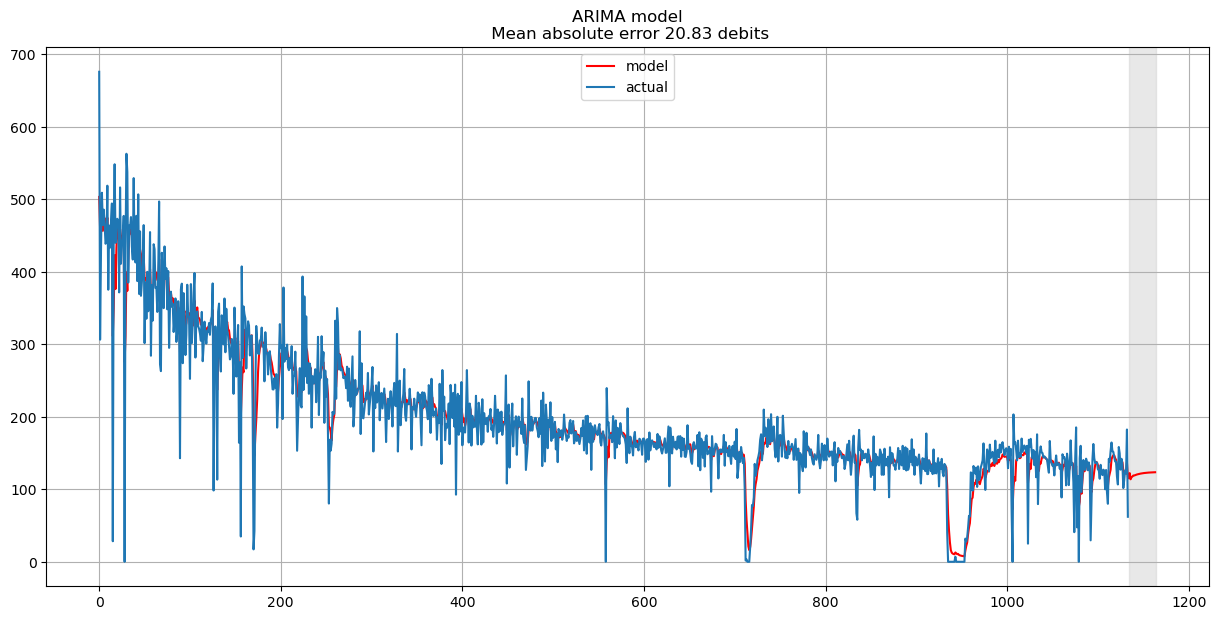

In [29]:
data["arima_model"] = invboxcox(arima_model.fittedvalues, lmbda)
forecast = invboxcox(arima_model.predict(start = data.shape[0], end = data.shape[0]+30), lmbda)
forecast = data.arima_model.append(forecast).values[-1164:]
actual = data.time_series.values[-1134:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
mae = mean_absolute_error(data.dropna().time_series[-30:],forecast[-30:])
plt.title(f"ARIMA model\n Mean absolute error {round(mae,2)} debits")
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [30]:
model1 = sm.tsa.statespace.SARIMAX(data.Debit_box[-1134:],
                                        exog=data[['Casing_Pressure_ksia', 'Tubing_Pressure_ksia', 'Active_Pressure_ksia', 'Line_Pressure_ksia','Calculated_Sandface_Pressure_ksia', 'water_thousand_bbl', 'Gas Lift Inj Volume  (MMscf)', 'Gas Volume (MMscf)' ]][-1134:],
                                        order=(1, 1, 1),
                                        seasonal_order=(1, 1, 1, 12)).fit(disp=-1)
print(model1.summary()) 

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

D:\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:                          Debit_box   No. Observations:                 1134
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3196.020
Date:                            Fri, 28 Jun 2024   AIC                           6418.039
Time:                                    14:15:17   BIC                           6483.325
Sample:                                01-31-2018   HQIC                          6442.714
                                     - 03-09-2021                                         
Covariance Type:                              opg                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Casing_Pressure_ksia                  1.9909      1.419      1.403  

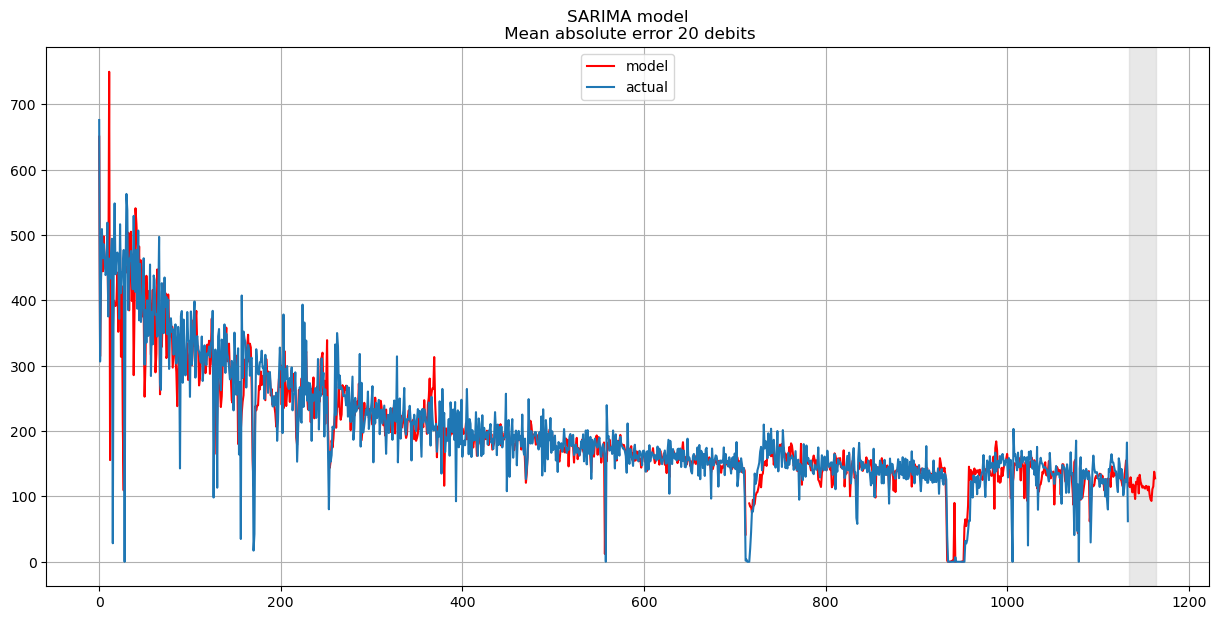

In [31]:
data["arima_model"] = invboxcox(model1.fittedvalues, lmbda)
forecast = invboxcox(model1.predict(start = data.shape[0], end = data.shape[0]+30,
                     exog=data[['Casing_Pressure_ksia', 'Tubing_Pressure_ksia', 'Active_Pressure_ksia', 'Line_Pressure_ksia','Calculated_Sandface_Pressure_ksia', 'water_thousand_bbl', 'Gas Lift Inj Volume  (MMscf)', 'Gas Volume (MMscf)' ]][-61:]),
                     lmbda)
forecast = data.arima_model.append(forecast).values[-1164:]
actual = dataset.time_series.values[-1134:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} debits".format(round(mean_absolute_error(data.dropna().time_series, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

In [32]:
mae_test = mean_absolute_error(data.dropna().time_series[-30:],data.dropna().arima_model[-30:])
mae_test

16.187651705020908

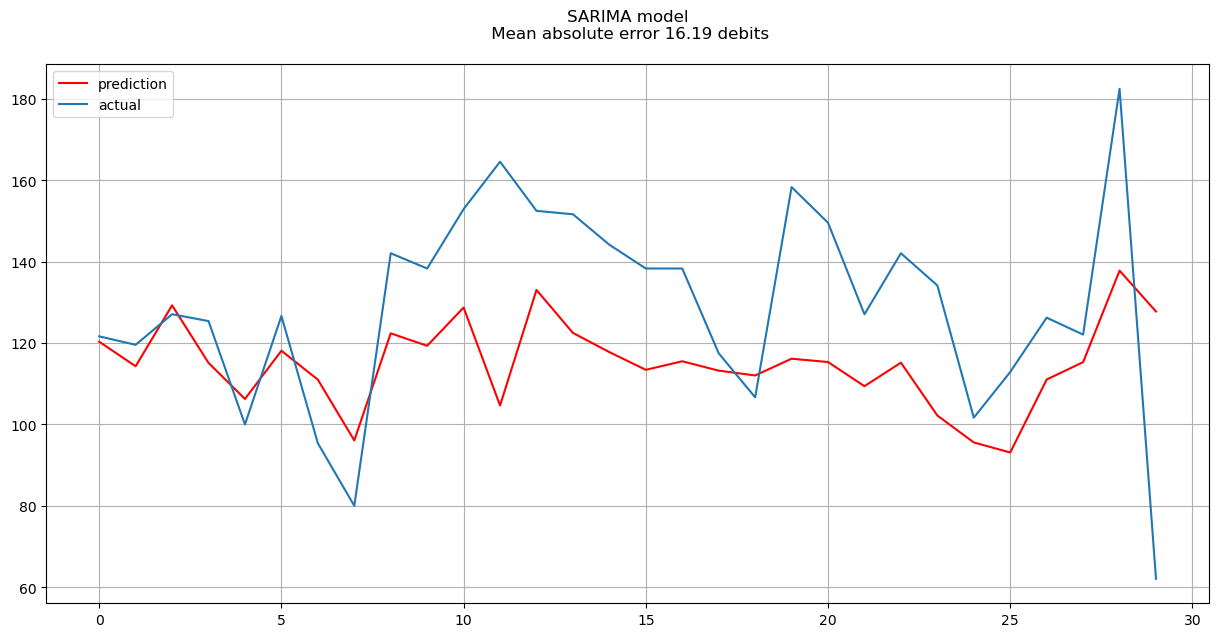

In [33]:
plt.figure(figsize=(15, 7))
plt.plot(forecast[-30:], "r", label="prediction")
plt.plot(dataset.time_series.values[-30:], label="actual")
plt.legend(loc="best")
plt.title(f"SARIMA model\n Mean absolute error {round(mae_test,2)} debits\n")
plt.grid(True);

Критерий Дики-Фуллера: p=0.000000


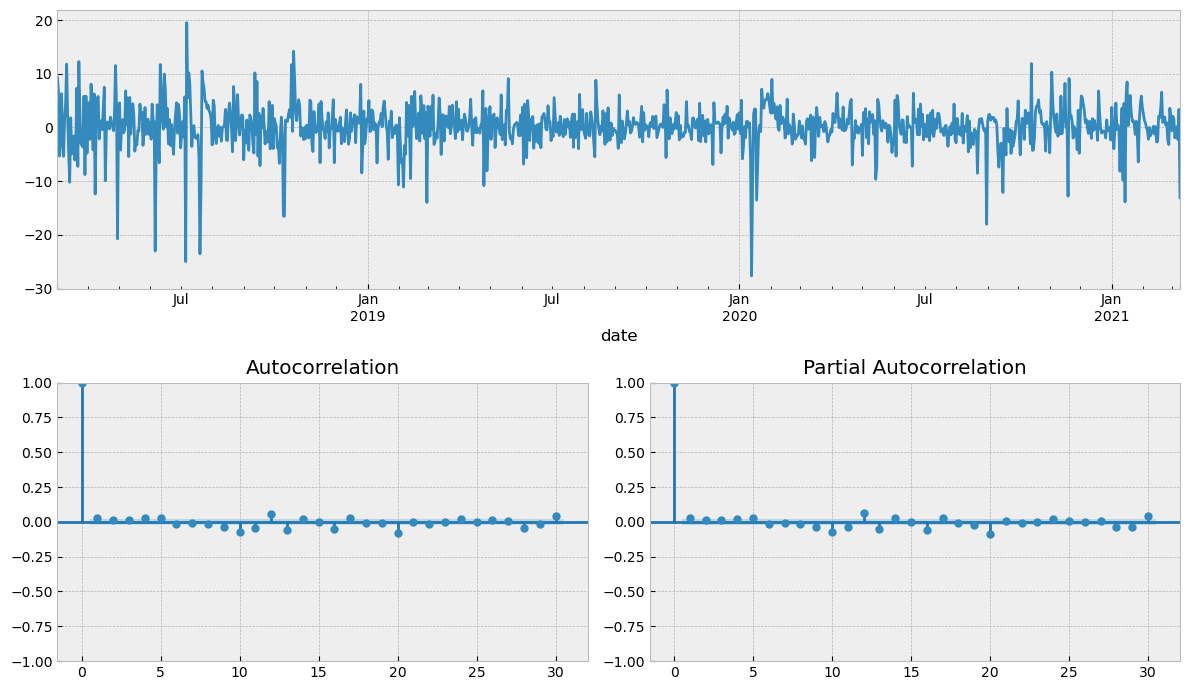

In [35]:
tsplot(model1.resid[30:], lags=30)

In [36]:
best_model1 = sm.tsa.statespace.SARIMAX(data.Debit_box, order=(4, 1, 4), 
                                        seasonal_order=(4, 0, 0, 12)).fit(disp=-1)
print(best_model1.summary())   

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

D:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

D:\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:                           Debit_box   No. Observations:                 1164
Model:             SARIMAX(4, 1, 4)x(4, 0, [], 12)   Log Likelihood               -3650.130
Date:                             Fri, 28 Jun 2024   AIC                           7326.261
Time:                                     14:17:16   BIC                           7392.025
Sample:                                 01-01-2018   HQIC                          7351.072
                                      - 03-09-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6147      0.387      1.587      0.112      -0.144       1.374
ar.L2          0.1233      

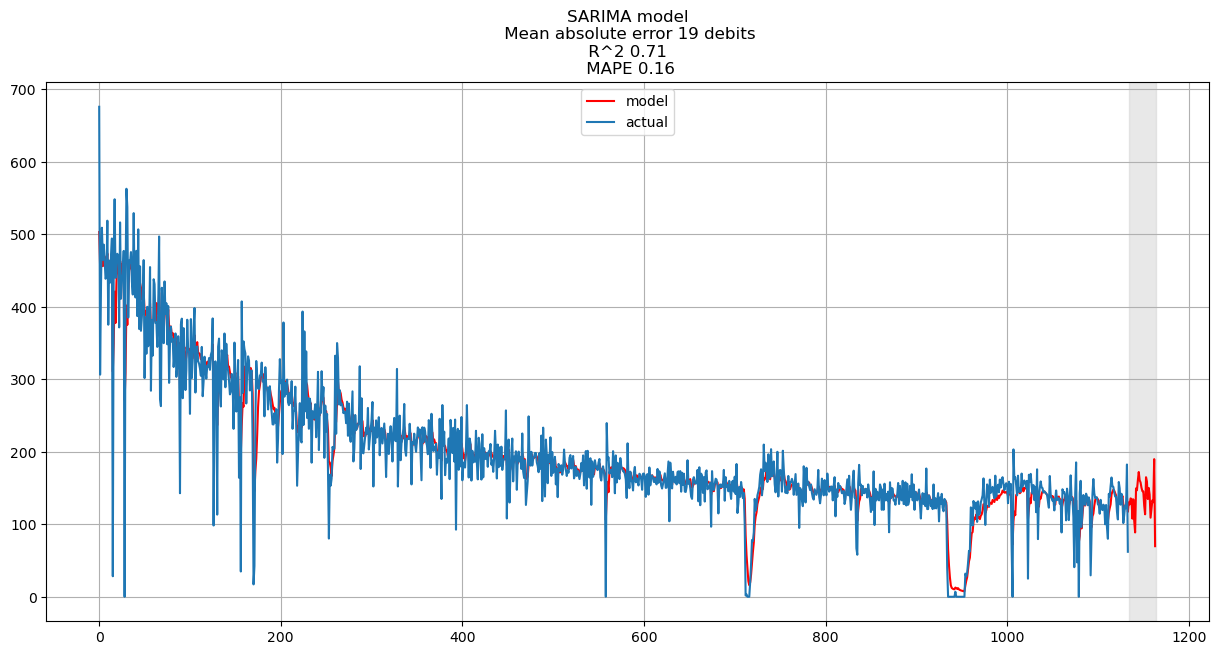

In [45]:
data["arima_model"] = invboxcox(best_model1.fittedvalues, lmbda)
forecast1 = invboxcox(best_model1.predict(start = data.shape[0], end = data.shape[0]+30), lmbda)
forecast1 = data.arima_model.append(forecast1).values[-1164:]
actual = data.time_series.values[-1134:]
plt.figure(figsize=(15, 7))
plt.plot(forecast1, color='r', label="model")

plt.title(f"SARIMA model\n Mean absolute error {round(mean_absolute_error(prediction, y_test))} debits\n R^2 {round(r2_score(prediction, y_test),2)}\n MAPE {round(mean_absolute_percentage_error(prediction, y_test),2)}")
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

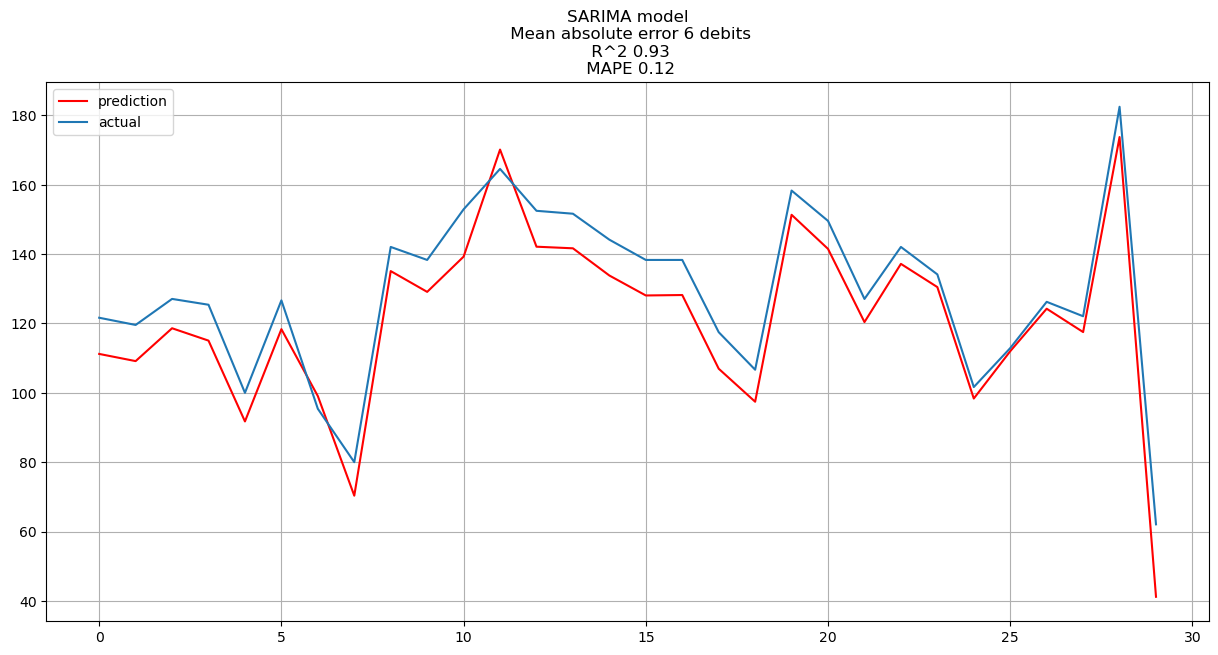

In [54]:
plt.figure(figsize=(15, 7))
plt.plot(forecast[-30:], "r", label="prediction")
plt.plot(dataset.time_series.values[-30:], label="actual")
plt.legend(loc="best")
plt.title(f"SARIMA model\n Mean absolute error {round(mean_absolute_error(prediction, y_test))} debits\n R^2 {round(r2_score(prediction, y_test),2)}\n MAPE {round(mean_absolute_percentage_error(prediction, y_test),2)}")
plt.grid(True);


Критерий Дики-Фуллера: p=0.000000


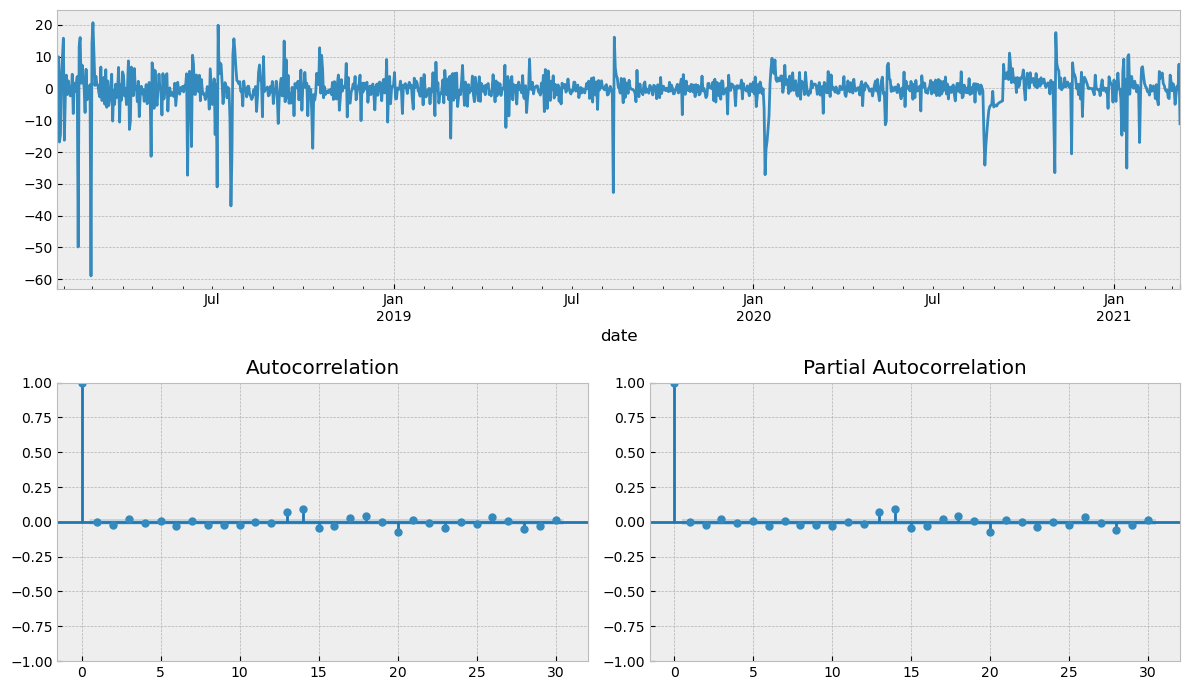

In [55]:
tsplot(best_model1.resid[24:], lags=30)